# Revisor Sistemático de Literatura Automatizado

O seguinte projeto tem como pretensão autimatizar o processo de Revisão Sistemática de Literatura (RSL) a partir da base da PubMed, que apesar do nome possúi uma infinidade de trabvalhos das mais diversas áreas. Os passos a serem seguidos são simples, sendo o principal deles a definição de uma estratégia de pesquisa, ou seja, quais termos chave, recortes temporais, de idioma e de tipo de paper serão feitos a busca automatizada.
\\
Ainda assim, é importante saber os motivos pelos quais a RSL é uma metodologia amplamente utilizada na fronteira do conhecimento, bem como suas limitações e casos de uso, não apenas utilizando esse scrit indiscriminadamente. A definição da estratégia de busca passa por um processo de entender a metodologia mas também de tentativa e erro.

Esse script é um exemplo que usa como base as palavras chaves e recortes que efini para a minha dissetação **COLETIVIDADE E INFRAESTRUTURA NO COMBATE A VIOLÊNCIA URBANA NA
JUVENTUDE: O CASO DA REDE CUCA EM FORTALEZA** desenvolvida para o PPGS-UFC

## Pacotes 

In [1]:
from Bio import Entrez
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
from tqdm import tqdm
from datetime import datetime
from graphviz import Digraph

## Estratégia de Pesquisa

In [16]:
search_strategy = {
    "terms": [
        # Violência juvenil
        "youth violence", "adolescent violence", "juvenile violence",
        "gang violence", "urban violence", "street violence",
        "community violence", "school violence",
        
        # Centros e programas
        "youth center", "community center", "youth club",
        "recreation center", "after-school program", "mentoring program",
        "social program", "youth development program", "youth empowerment",
        
        # Políticas públicas e intervenções
        "public policy", "social policy", "crime prevention program",
        "violence prevention", "community intervention", "crime reduction",
        "juvenile justice program", "preventive measures",
        
        # Termos gerais
        "at-risk youth", "delinquent behavior", "antisocial behavior",
        "gang prevention", "community engagement", "youth participation"
    ],
    "databases": ["PubMed"],
    "date_range": ("2020/01/01", "2025/09/30"), # Recorte Temporal
    "filters": {
        "language": ["English", "Portuguese"], # Recorte Linguístico
        "article_types": ["Journal Article", "Review", "Working Paper"] # Recorte de Tipo de Paper
    },
    "search_date": datetime.now()
}

## Busca no PubMed

In [17]:
def search_pubmed(term, max_results=300):
    handle = Entrez.esearch(
        db="pubmed",
        term=term,
        retmax=max_results,
        datetype="pdat",
        mindate=search_strategy["date_range"][0],
        maxdate=search_strategy["date_range"][1]
    )
    record = Entrez.read(handle)
    handle.close()
    ids = record["IdList"]
    return ids

In [18]:
all_results = []
for term in tqdm(search_strategy["terms"], desc="Buscando no PubMed"):
    ids = search_pubmed(term)
    if ids:
        for article_id in ids:
            all_results.append({"id": article_id, "term": term})

Buscando no PubMed:   0%|          | 0/31 [00:00<?, ?it/s]C:\Users\User\AppData\Roaming\Python\Python310\site-packages\Bio\Entrez\__init__.py:734: UserWarning: 
            Email address is not specified.

            To make use of NCBI's E-utilities, NCBI requires you to specify your
            email address with each request.  As an example, if your email address
            is A.N.Other@example.com, you can specify it as follows:
               from Bio import Entrez
               Entrez.email = 'A.N.Other@example.com'
            In case of excessive usage of the E-utilities, NCBI will attempt to contact
            a user at the email address provided before blocking access to the
            E-utilities.
  warnings.warn(
Buscando no PubMed: 100%|██████████| 31/31 [00:18<00:00,  1.66it/s]


In [19]:
resultados_brutos = pd.DataFrame(all_results).drop_duplicates("id")

## Coletando Dados dos Artigos

In [ ]:
def fetch_details(id_list):
    ids = ",".join(id_list)
    handle = Entrez.efetch(db="pubmed", id=ids, rettype="medline", retmode="xml")
    records = Entrez.read(handle)
    handle.close()

    data = []
    for rec in records["PubmedArticle"]:
        art = rec["MedlineCitation"]["Article"]
        title = art.get("ArticleTitle", "")
        abstract = art.get("Abstract", {}).get("AbstractText", [""])[0]
        journal = art.get("Journal", {}).get("Title", "")
        year = None
        try:
            date_info = art.get("Journal", {}).get("JournalIssue", {}).get("PubDate", {})
            if "Year" in date_info:
                year = int(date_info["Year"])
            elif "MedlineDate" in date_info:

                match = re.search(r"\b(19|20)\d{2}\b", date_info["MedlineDate"])
                if match:
                    year = int(match.group(0))
        except:
            pass

        data.append({
            "id": rec["MedlineCitation"]["PMID"],
            "title": title,
            "abstract": abstract,
            "journal": journal,
            "year": year
        })
    return pd.DataFrame(data)

In [21]:
ids = resultados_brutos["id"].tolist()
chunks = [ids[i:i+100] for i in range(0, len(ids), 100)]
resultados_detalhados = pd.concat([fetch_details(chunk) for chunk in tqdm(chunks, desc="Baixando metadados")])

Baixando metadados:   0%|          | 0/69 [00:00<?, ?it/s]C:\Users\User\AppData\Roaming\Python\Python310\site-packages\Bio\Entrez\__init__.py:734: UserWarning: 
            Email address is not specified.

            To make use of NCBI's E-utilities, NCBI requires you to specify your
            email address with each request.  As an example, if your email address
            is A.N.Other@example.com, you can specify it as follows:
               from Bio import Entrez
               Entrez.email = 'A.N.Other@example.com'
            In case of excessive usage of the E-utilities, NCBI will attempt to contact
            a user at the email address provided before blocking access to the
            E-utilities.
  warnings.warn(
Baixando metadados:   1%|▏         | 1/69 [00:01<02:11,  1.93s/it]C:\Users\User\AppData\Roaming\Python\Python310\site-packages\Bio\Entrez\__init__.py:734: UserWarning: 
            Email address is not specified.

            To make use of NCBI's E-utilities,

## Retirando Duplicatas e Identificando o Padrão Ouro

In [22]:
resultados_detalhados = resultados_detalhados.drop_duplicates(subset=["title"])
resultados_detalhados["duplicate"] = False

In [23]:
pattern = "|".join([re.escape(t.lower()) for t in search_strategy["terms"]])

padrao_ouro = resultados_detalhados[resultados_detalhados["title"].str.lower().str.contains(pattern, na=False)]
padrao_ouro_ids = padrao_ouro["id"].tolist()

## Métricas Simples, DataViz e Fluxograma PRISMA

A ideia aqui é calcular três métricas simples para avaliar o desempenho do modelo, evitando falsos negativos e falsos positivos no resultado final

- **Precision (Precisão):** Entre os artigos que o programa entendeu como relevante, quantos são de fato. Matemáticamente representado por 
$
\text{Precisão} = \frac{\text{True Positives}}{\text{True Positives + False Positives}}
$

- **Recall:** Entre todos os artigos que são relevantes, quantos o sistema conseguiu encontrar. Matematicamente dado por 
$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}}
$

- **F1:** Média Harmônica entre Precisão e Recall. Representado por: 
$
F_1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision + Recall}}
$

In [24]:
total = len(resultados_detalhados)
identificados = len(padrao_ouro)
precision = identificados / total if total else 0
recall = 1.0  
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Precision: 0.023
Recall: 1.000
F1 Score: 0.045


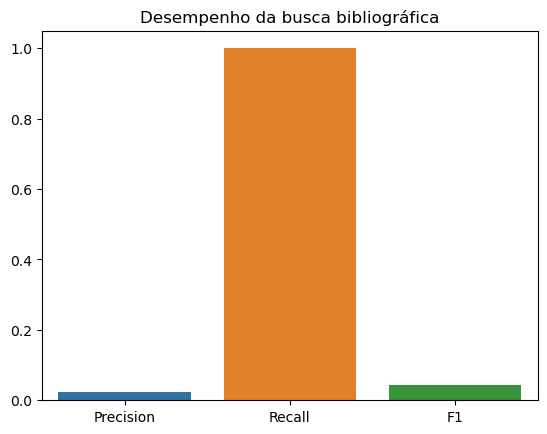

In [25]:
sns.barplot(x=["Precision", "Recall", "F1"], y=[precision, recall, f1])
plt.title("Desempenho da busca bibliográfica")
plt.show()

In [26]:

dados_limpos = pd.DataFrame({
    "id": resultados_detalhados["id"],
    "identified": True,
    "duplicate": False,
    "title_abstract_screened": True,
    "full_text_eligible": [random.random() > 0.7 for _ in range(len(resultados_detalhados))],
    "included": [random.random() > 0.85 for _ in range(len(resultados_detalhados))],
})

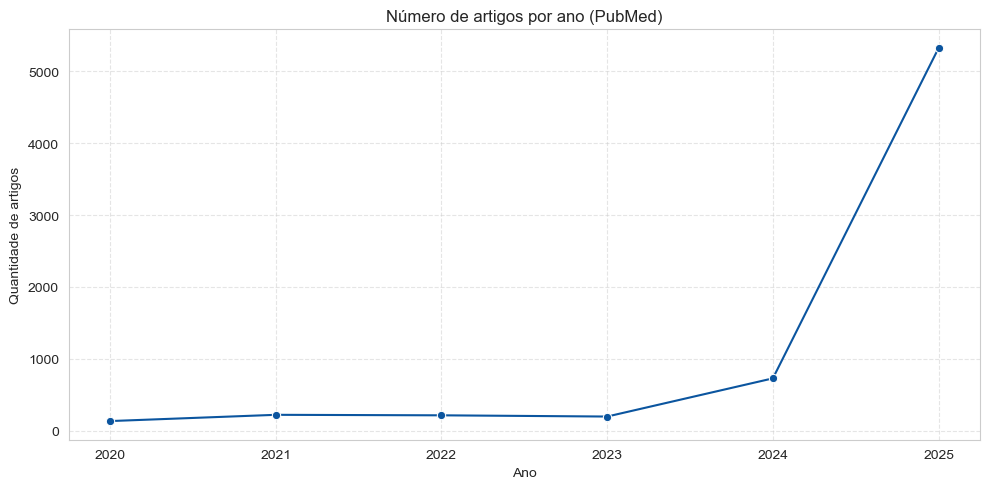

In [ ]:
plt.figure(figsize=(10, 5))

artigos_por_ano = (
    resultados_detalhados["year"]
    .dropna()
    .astype(int)
    .value_counts()
    .sort_index()
)

artigos_por_ano = artigos_por_ano[artigos_por_ano.index != 2026]

sns.lineplot(x=artigos_por_ano.index, y=artigos_por_ano.values, marker="o")
plt.title("Número de artigos por ano (PubMed)")
plt.xlabel("Ano")
plt.ylabel("Quantidade de artigos")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

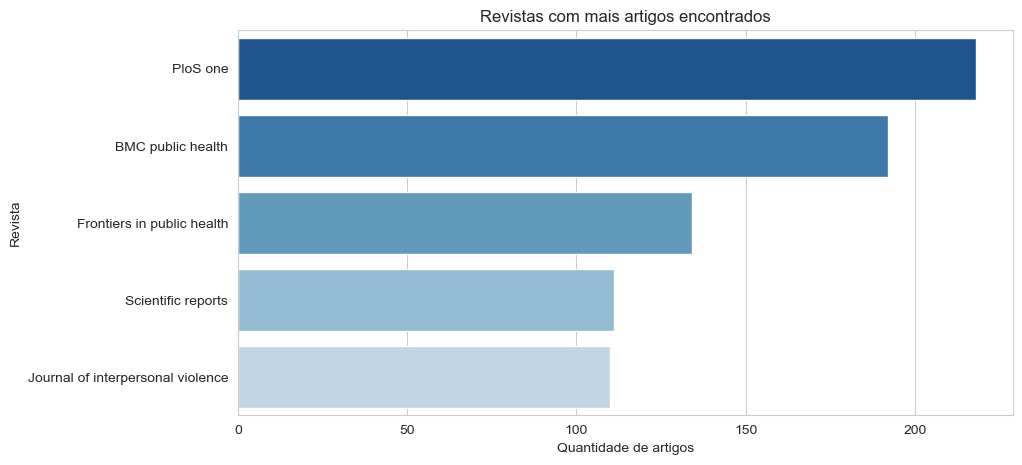

In [35]:
plt.figure(figsize=(10, 5))
top_revistas = resultados_detalhados["journal"].value_counts().head(5)
sns.barplot(y=top_revistas.index, x=top_revistas.values)
plt.title("Revistas com mais artigos encontrados")
plt.xlabel("Quantidade de artigos")
plt.ylabel("Revista")
plt.show()

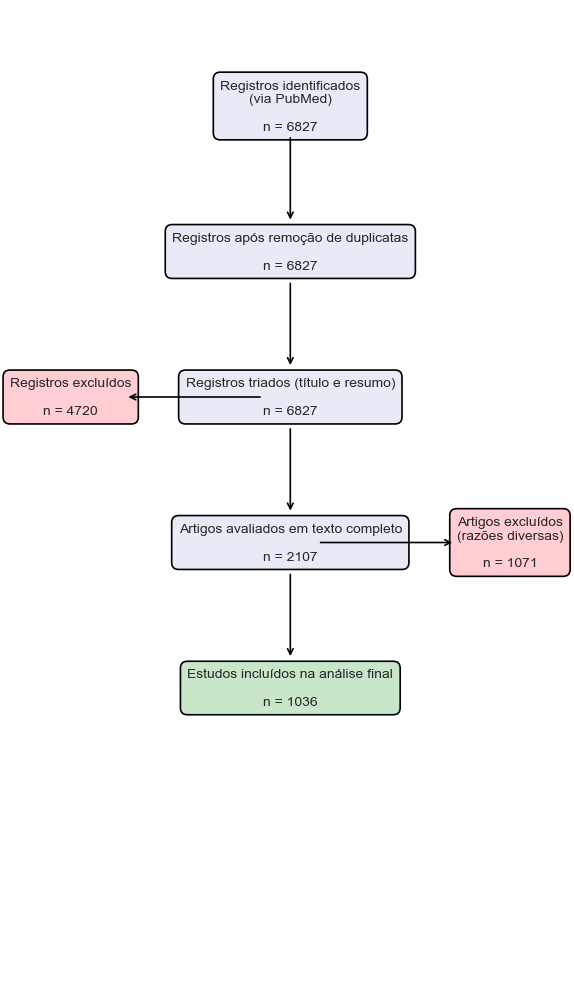

In [38]:
total_identificados = len(resultados_detalhados)
apos_duplicatas = len(resultados_detalhados)
avaliados = int(sum(dados_limpos["full_text_eligible"]))
incluidos = int(sum(dados_limpos["included"]))
excluidos_triagem = apos_duplicatas - avaliados
excluidos_texto = avaliados - incluidos

fig, ax = plt.subplots(figsize=(6, 10))
ax.axis('off')

def caixa(texto, xy, color="#E8EAF6"):
    box = dict(boxstyle="round,pad=0.5", facecolor=color, edgecolor="black", linewidth=1.2)
    ax.text(xy[0], xy[1], texto, ha="center", va="center", fontsize=10, bbox=box)

caixa(f"Registros identificados\n(via PubMed)\n\nn = {total_identificados}", (0.5, 0.9))
caixa(f"Registros após remoção de duplicatas\n\nn = {apos_duplicatas}", (0.5, 0.75))
caixa(f"Registros triados (título e resumo)\n\nn = {apos_duplicatas}", (0.5, 0.6))

caixa(f"Registros excluídos\n\nn = {excluidos_triagem}", (0.1, 0.6), color="#FFCDD2")  
caixa(f"Artigos avaliados em texto completo\n\nn = {avaliados}", (0.5, 0.45))
caixa(f"Artigos excluídos\n(razões diversas)\n\nn = {excluidos_texto}", (0.9, 0.45), color="#FFCDD2")  
caixa(f"Estudos incluídos na análise final\n\nn = {incluidos}", (0.5, 0.3), color="#C8E6C9")

setas = [
    ((0.5, 0.87), (0.5, 0.78)),
    ((0.5, 0.72), (0.5, 0.63)),
    ((0.5, 0.57), (0.5, 0.48)),
    ((0.5, 0.42), (0.5, 0.33))
]
for (x1, y1), (x2, y2) in setas:
    ax.annotate("", xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle="->", lw=1.2, color="black"))

ax.annotate("", xy=(0.2, 0.6), xytext=(0.45, 0.6), arrowprops=dict(arrowstyle="->", lw=1.2, color="black"))
ax.annotate("", xy=(0.8, 0.45), xytext=(0.55, 0.45), arrowprops=dict(arrowstyle="->", lw=1.2, color="black"))

plt.tight_layout()
plt.show()

## Exportanto Resultados

In [14]:

artigos_incluidos = resultados_detalhados[resultados_detalhados["id"].isin(
    dados_limpos.loc[dados_limpos["included"], "id"]
)]

artigos_incluidos.to_excel("artigos_incluidos.xlsx", index=False)